<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-Linear-Regressor" data-toc-modified-id="Модель-Linear-Regressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель Linear Regressor</a></span></li><li><span><a href="#Модель-Random-Forest" data-toc-modified-id="Модель-Random-Forest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель Random Forest</a></span></li><li><span><a href="#Модель-Light-GBM-Regressor" data-toc-modified-id="Модель-Light-GBM-Regressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель Light GBM Regressor</a></span></li><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [ ]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [ ]:
print(df.info())
print()
print(df.describe())
print()
print(df.isnull().sum())
print()
print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None

         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

num_orders    0
dtype: int64

26415


In [ ]:
df.sort_index(inplace=True)
df.index.is_monotonic

True

Дубликаты отсутствуют, пропуски отсутствуют, данные упорядочены по индексу и готовы к дальнейшему анализу.

## Анализ

Сначала выполним ресемплирование данных по одному часу:

<AxesSubplot:xlabel='datetime'>

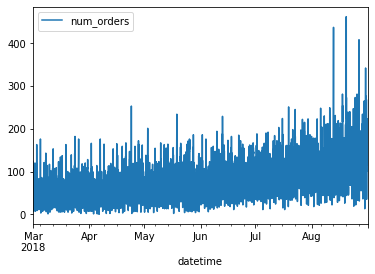

In [ ]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.plot()

Теперь построим график скользящего среднего.

<AxesSubplot:title={'center':'Скользящее среднее'}, xlabel='datetime'>

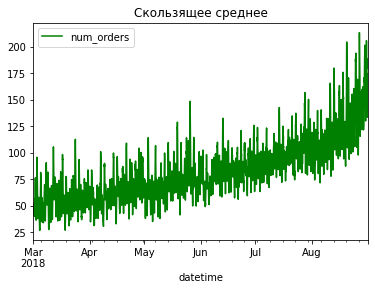

In [ ]:
df.rolling(10).mean().plot(title='Скользящее среднее', color='green')

<AxesSubplot:title={'center':'Тренд'}, xlabel='datetime'>

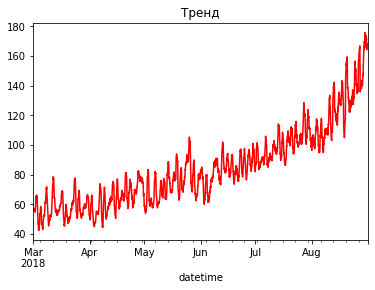

In [ ]:
decomposed = seasonal_decompose(df)
decomposed.trend.plot(title='Тренд', color='red')

<AxesSubplot:title={'center':'Сезонность'}, xlabel='datetime'>

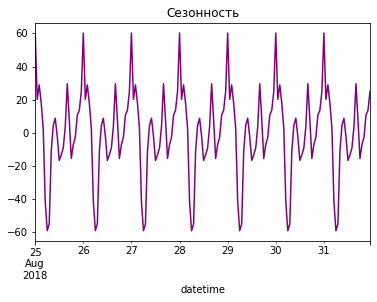

In [ ]:
decomposed.seasonal.tail(24*7).plot(title='Сезонность', color='purple')

<AxesSubplot:title={'center':'Остатки'}, xlabel='datetime'>

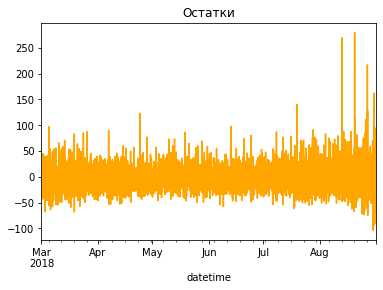

In [ ]:
decomposed.resid.plot(title='Остатки', color='orange')

По распределению на графиках можно наблюдать восходящий тренд, есть сезонность в течение дня.

## Обучение

Теперь обучим разные модели с различными гиперпараметрами. 
Сделать тестовую выборку размером 10% от исходных данных.

In [ ]:
df = df.resample('1H').sum()
# напишем функцию, которая создает признаки, чтобы прибавить к датасету календарные признаки
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 10, 10)

In [ ]:
df

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,173.3
2018-08-31 20:00:00,154,20,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,166.6
2018-08-31 21:00:00,159,21,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,162.9


In [ ]:
# разделим данные на тренировочные и  10% тестовых
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [ ]:
# выделим признаки
features = train.drop('num_orders', axis = 1)
target = train['num_orders']
features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

In [ ]:
# проверим все ли данные корректно разделились
print(f'Обучающие данные: {features.shape[0]}\nТренировочные: {features_test.shape[0]}')

Обучающие данные: 3964
Тренировочные: 442


In [ ]:
# напишем функцию, которая возвращает RMSE
def RMSE(target, predict):
    
    RMSE = mean_squared_error(target, predict) ** 0.5
    
    return RMSE

In [ ]:
# сделаем параметр из функции
rmse_score = make_scorer(RMSE, greater_is_better=False) 

### Модель Linear Regressor

С помощью кросс-валидации и заранее подготовленного параметра посчитаем RMSE линейной регрессии на обучающей выборке.

In [ ]:
tscv = TimeSeriesSplit()

In [ ]:
lr = LinearRegression()
lr.fit(features, target)
scores = cross_val_score(lr, features, target, scoring=rmse_score, cv=tscv)
print("RMSE на обучающей выборке:", scores.mean())

RMSE на обучающей выборке: -32.592618530319555


### Модель Random Forest

In [ ]:
rf = RandomForestRegressor()

In [ ]:
# подберем параметры
parameters_grid = {'max_depth': range(2, 21, 2),
          'n_estimators': range(10, 101, 10)}

grid_rf = GridSearchCV(rf, param_grid=parameters_grid, scoring=rmse_score, cv=tscv)
grid_rf.fit(features, target)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(2, 21, 2),
                         'n_estimators': range(10, 101, 10)},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [ ]:
grid_rf.best_params_

{'max_depth': 20, 'n_estimators': 80}

In [ ]:
print("RMSE на обучающей выборке:", grid_rf.best_score_)

RMSE на обучающей выборке: -25.579291084313013


RMSE является наилучшим среди всех моделей.

### Модель Light GBM Regressor

In [ ]:
lgbm = LGBMRegressor()

In [ ]:
# подберем параметры
params = {'max_depth': [10, 20, 30],
          'learning_rate': [0.05, 0.1, 0.2]}

grid_lgb = GridSearchCV(lgbm, params, cv=tscv, scoring=rmse_score)
grid_lgb.fit(features, target)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [10, 20, 30]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [ ]:
grid_lgb.best_params_

{'learning_rate': 0.05, 'max_depth': 30}

In [ ]:
print("RMSE на обучающей выборке:", grid_lgb.best_score_)

RMSE на обучающей выборке: -25.905500317130183


### Выводы:
Хороший показатель RMSE получился у модели **Random Forest**, поэтому дальше тестировать будем именно ее.

## Тестирование

In [ ]:
start = time.time()
predictions_test = grid_rf.predict(features_test)
print(f'Время предсказания = {(time.time() - start):.4f} секунд')

print('-----------------------------------------------')
print('RMSE =', RMSE(target_test, predictions_test))

Время предсказания = 0.0142 секунд
-----------------------------------------------
RMSE = 44.88429787114984


По сравнению с RMSE на тренировочных данных, на тестовых показатель сильно ухудшился, но все еще находится ниже порогового значения (не больше 48), поэтому можно заключить, что модель корректно работает и показывает результат.